In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import circuit_simulator as cs

In [4]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensornetwork as tn

# April 10 update

# Quick benchmark

In [5]:
noise_level = 0.01

In [ ]:
# Similar code to above, but with the new definitions for sampling

In [6]:
ps = []
for x in tqdm(range(2000)):
    ps.append(cs.sample_all_qubits_faster(50, depolarizing_noise = noise_level))
ps = np.array(ps)

In [7]:
# when things are not the same
ps_nosame = []
for x in tqdm(range(2000)):
    ps_nosame.append(cs.sample_all_qubits_faster(50, all_same=False, depolarizing_noise = noise_level))
ps_nosame = np.array(ps_nosame)

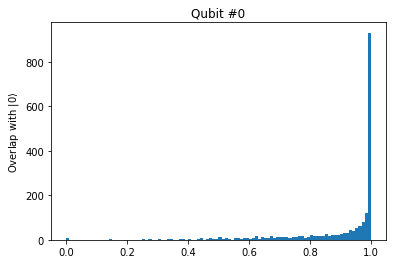

In [8]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.ylabel(r"Overlap with $|0\rangle$")
plt.show()

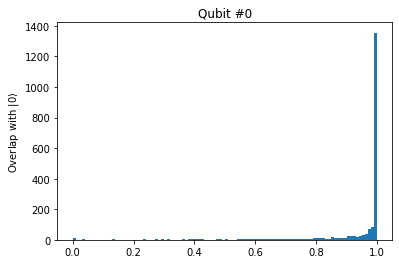

In [9]:
plt.hist(ps_nosame[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.ylabel(r"Overlap with $|0\rangle$")
plt.show()

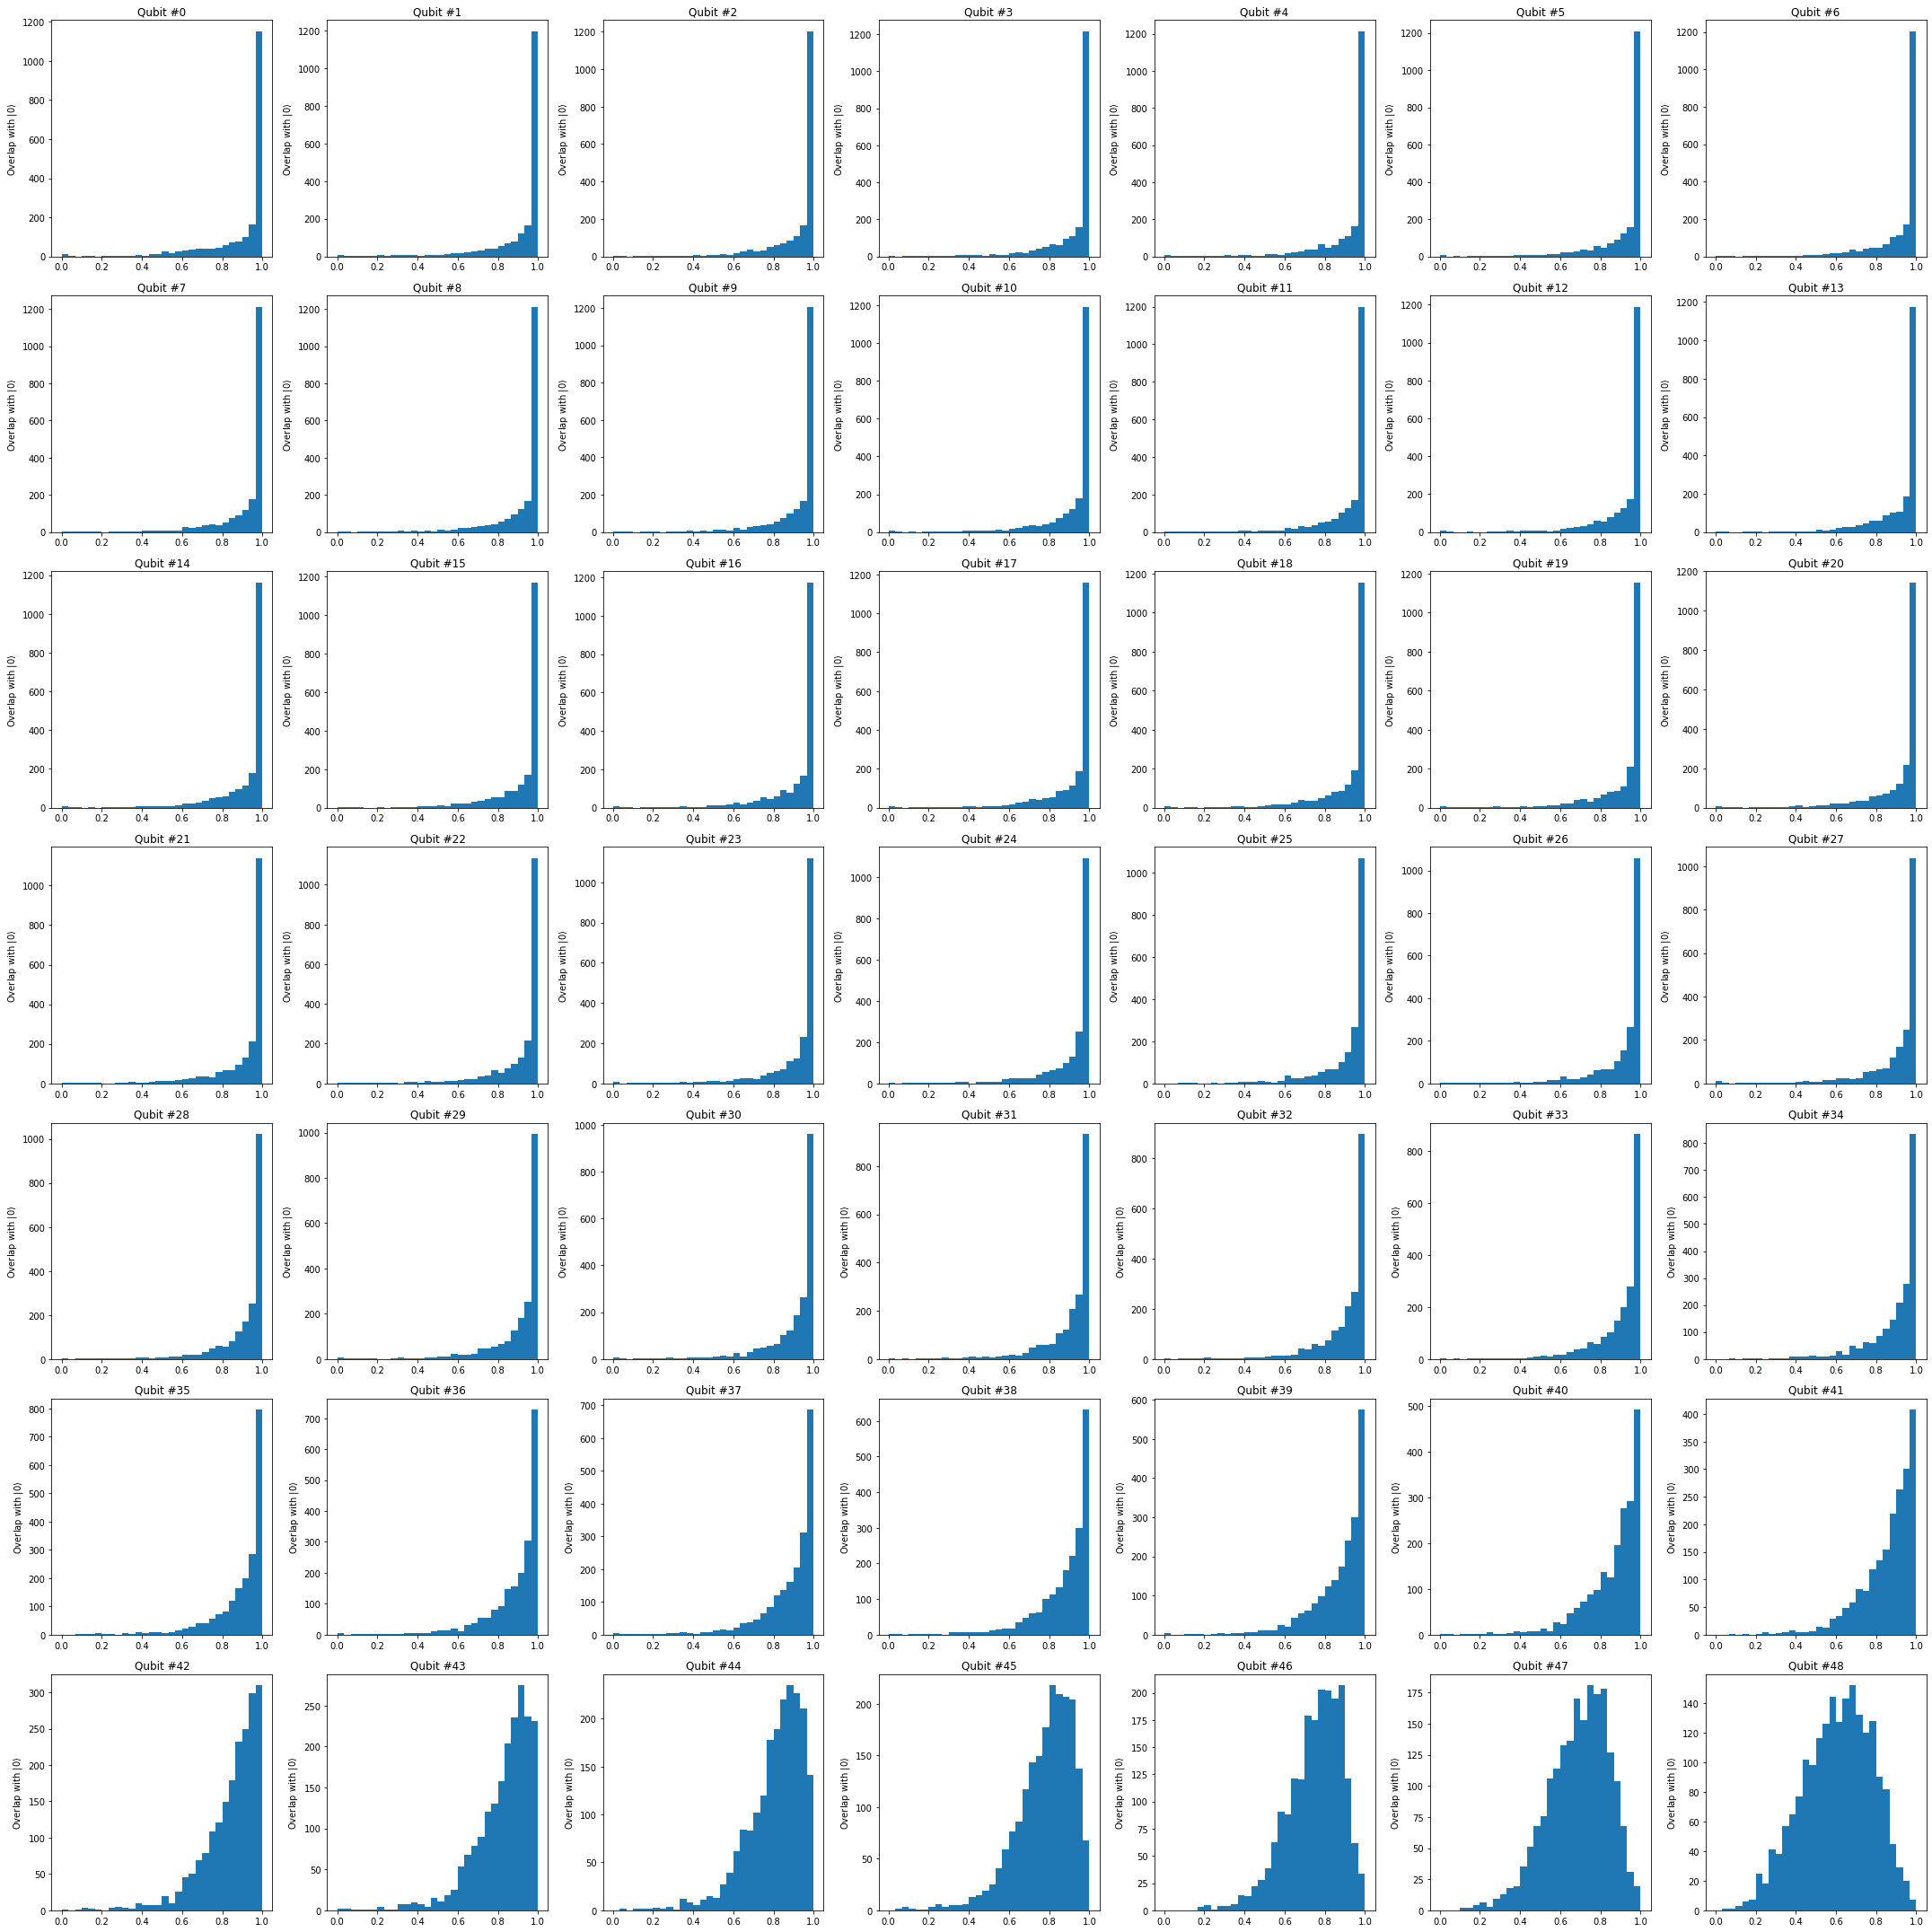

In [10]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_ylabel(r"Overlap with $|0\rangle$")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


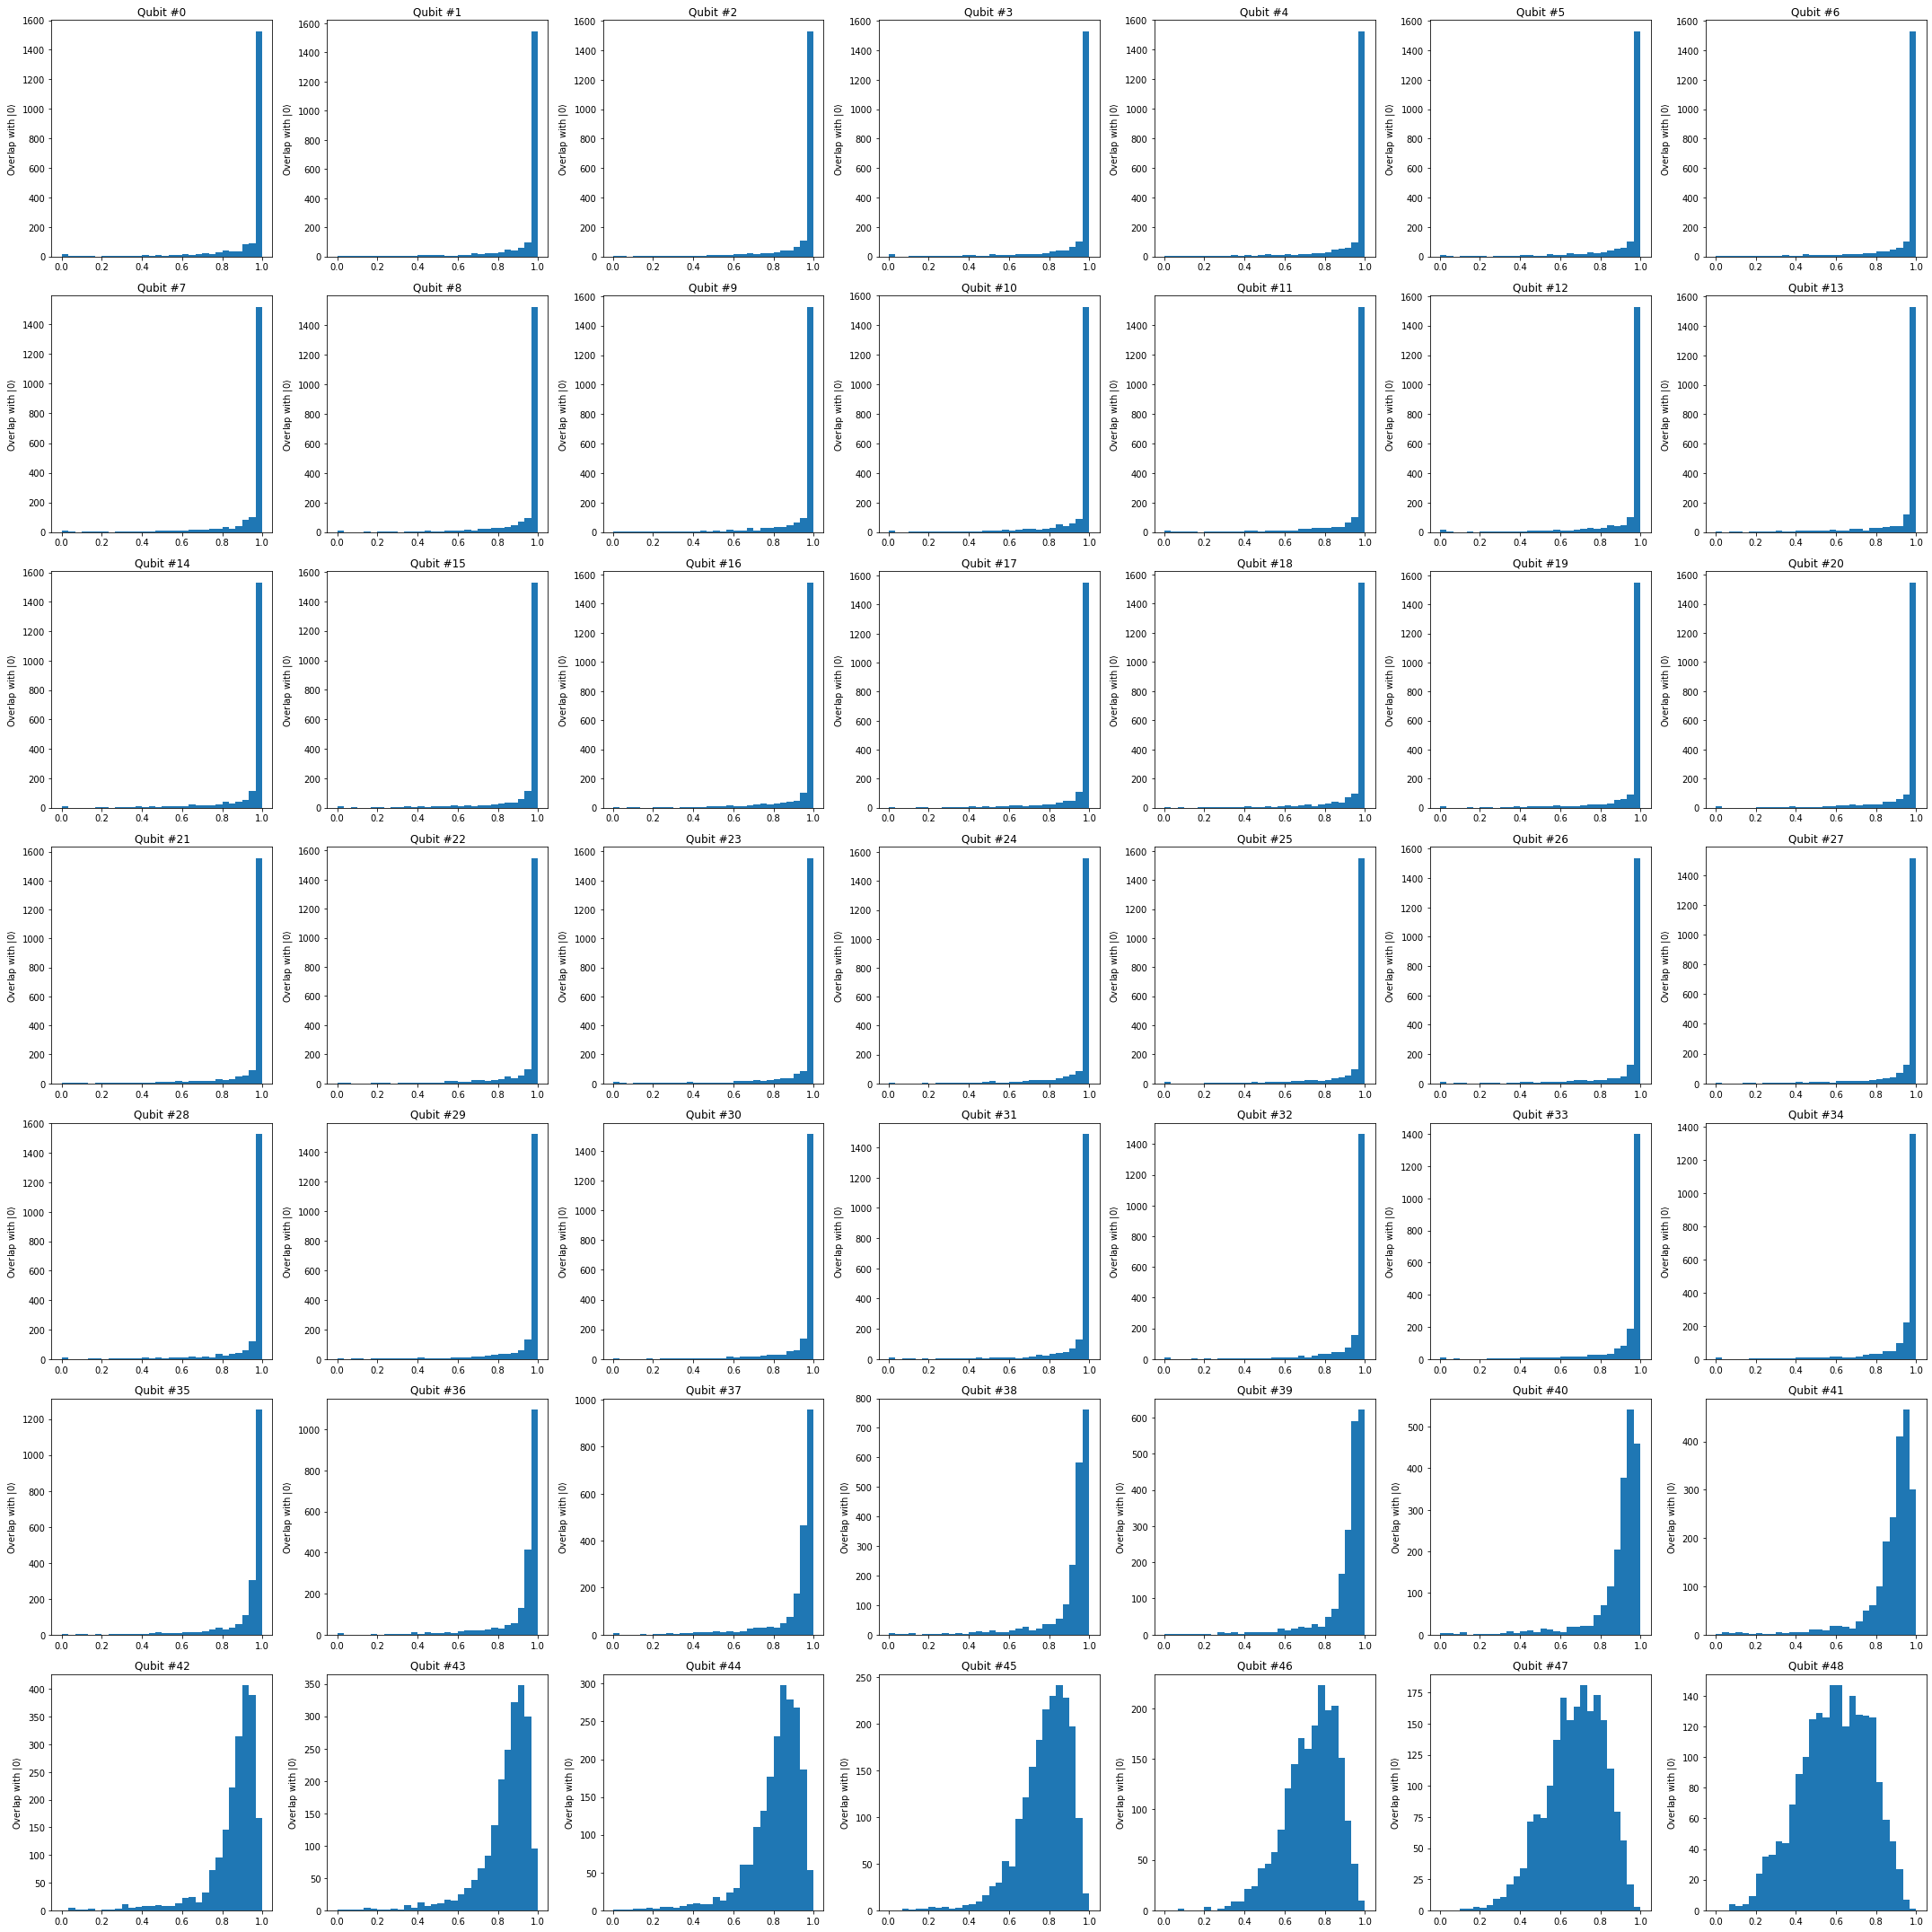

In [11]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps_nosame[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_ylabel(r"Overlap with $|0\rangle$")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


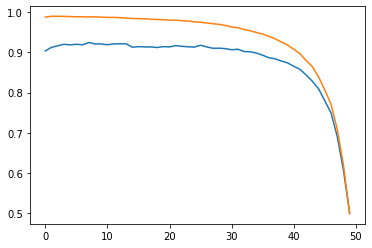

In [12]:
#blue is mean, orange is median
plt.plot(np.mean(ps,axis=0))
plt.plot(np.median(ps,axis=0))
plt.show()

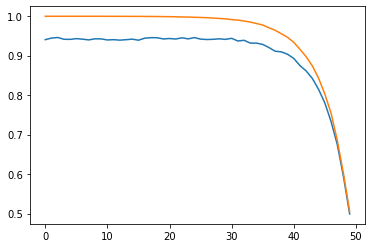

In [13]:
plt.plot(np.mean(ps_nosame,axis=0))
plt.plot(np.median(ps_nosame,axis=0))
plt.show()

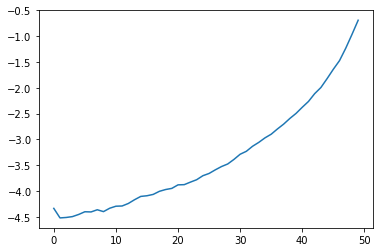

In [14]:
plt.plot(np.log(1-np.median(ps, axis=0)))
plt.show()

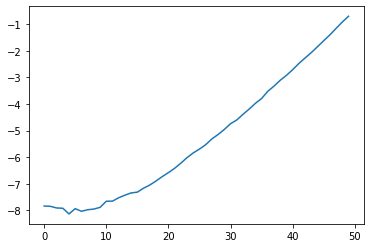

In [15]:
plt.plot(np.log(1-np.median(ps_nosame, axis=0)))
plt.show()

In [16]:
# Fitting the exponential
from sklearn.linear_model import LinearRegression 

In [17]:
lr = LinearRegression()
lr.fit(np.array([np.arange(50)]).T, np.log(1-np.median(ps, axis=0)))
lr.coef_[0], lr.intercept_

(0.06770077777114794, -5.017315115764026)

In [18]:
#R2
lr.score(np.array([np.arange(50)]).T, np.log(1-np.median(ps, axis=0)))

0.9012325523812021

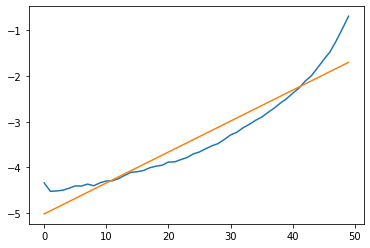

In [19]:
plt.plot(np.log(1-np.median(ps, axis=0)))
plt.plot(np.arange(50)*lr.coef_[0] + lr.intercept_)

In [20]:
lr = LinearRegression()
lr.fit(np.array([np.arange(50)]).T, np.log(1-np.median(ps_nosame, axis=0)))
lr.coef_[0], lr.intercept_

(0.15786163325646013, -9.180967403707687)

In [21]:
#R2
lr.score(np.array([np.arange(50)]).T, np.log(1-np.median(ps_nosame, axis=0)))

0.9568092933238963

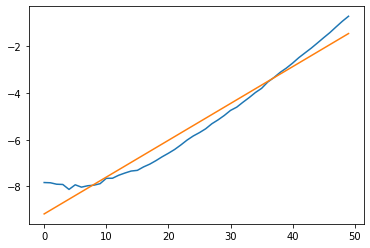

In [22]:
plt.plot(np.log(1-np.median(ps_nosame, axis=0)))
plt.plot(np.arange(50)*lr.coef_[0] + lr.intercept_)